In [0]:
! pip install scikit-plot

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile 

DATA = "feraligned+ck"
file_name = f"drive/My Drive/FER/datasets/{DATA}.zip"

with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall(DATA)
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import math
import joblib
import numpy as np

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Add
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
tf.__version__

'2.2.0-rc4'

In [0]:
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/AdvancedNetworks/"
DATA_PATH = f"{DATA}/{DATA}/"
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness", "Surprise", "Angry"]

TRAIN_SIZE = 0.86
INPUT_SHAPE = (48,48,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [0]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Neutral has 1230 number of images
Angry has 938 number of images
Surprise has 249 number of images
Sadness has 1153 number of images
Happy has 2203 number of images

total images are 5773


In [0]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img_arr.append(np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1,1))

img_arr.shape, img_label.shape, label_to_text

loaded Neutral images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Surprise images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


((5773, 48, 48, 1),
 (5773, 5),
 {0: 'Neutral', 1: 'Angry', 2: 'Surprise', 3: 'Sadness', 4: 'Happy'})

In [0]:
img_arr = img_arr / 255.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4964, 48, 48, 1), (809, 48, 48, 1), (4964, 5), (809, 5))

In [0]:
def identity_block(X, kernel: tuple, filters: list, stage: int, block_id: str):
    conv_name = 'idblock_conv_' +  str(stage) + f'_{block_id}'
    bn_name = 'idblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "idblock_actv_" + str(stage) + f'_{block_id}'
    
    X_shortcut = X
    
    X = Conv2D(
        filters = filters[0],
        kernel_size = (1, 1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)

    X = Conv2D(
        filters = filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters = filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_c',
        kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)
    
    return X

In [0]:
def convolutional_block(X, kernel: tuple, stride: tuple, filters: list, stage: int, block_id: str):    
    conv_name = 'convblock_conv_' + str(stage) + f'_{block_id}'
    bn_name = 'convblock_bn_' + str(stage) + f'_{block_id}'
    actv_name = "convblock_actv_" + str(stage) + f'_{block_id}'

    X_shortcut = X

    X = Conv2D(
        filters[0],
        kernel_size = (1, 1),
        strides = stride,
        name = conv_name + '_a',
        kernel_initializer = glorot_uniform(seed=0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_a')(X)
    X = Activation('relu', name = actv_name + '_a')(X)
    
    X = Conv2D(
        filters[1],
        kernel_size = kernel,
        strides = (1,1),
        padding = 'same',
        name = conv_name + '_b',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_b')(X)
    X = Activation('relu', name = actv_name + '_b')(X)

    X = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = (1,1),
        padding = 'valid',
        name = conv_name + '_c',
        kernel_initializer=glorot_uniform(seed =0)
    )(X)
    X = BatchNormalization(axis = 3, name = bn_name + '_c')(X)

    X_shortcut = Conv2D(
        filters[2],
        kernel_size = (1,1),
        strides = stride,
        padding = 'valid',
        name = conv_name + '_sc1',
        kernel_initializer=glorot_uniform(seed =0)
    )(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name + '_sc1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu', name = actv_name + '_c')(X)

    return X

In [0]:
def CNN_with_SkipConnections(input_shape, classes, show_summary=False):
    model_in = Input(input_shape)
    
    # # Block 0
    # X = Conv2D(
    #     filters = 32,
    #     kernel_size = (3,3),
    #     strides = (1,1),
    #     padding = 'valid',
    #     name = 'conv_0_a',
    #     kernel_initializer = glorot_uniform(seed=0)
    # )(model_in)
    # X = BatchNormalization(axis = 3, name = 'bn_0_a')(X)
    # X = Activation('relu', name="actv_0_a")(X)

    # X = Conv2D(
    #     filters = 64,
    #     kernel_size = (3,3),
    #     strides = (1,1),
    #     padding = 'valid',
    #     name = 'conv_0_b',
    #     kernel_initializer = glorot_uniform(seed=0)
    # )(X)
    # X = BatchNormalization(axis = 3, name = 'bn_0_b')(X)
    # X = Activation('relu', name="actv_0_b")(X)

    # Block 0
    X = convolutional_block(model_in, (3,3), stride=(1,1), filters = [32, 32, 64], stage=0, block_id='a')
    X = identity_block(X, (3,3), [32, 32, 64], stage=0, block_id='a')

    # Block 1
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [64, 64, 128], stage=1, block_id='a')
    X = identity_block(X, (3,3), [64, 64, 128], stage=1, block_id='a')
 
    # Block 2
    X = convolutional_block(X, (3,3), stride=(2,2), filters = [128,128,256], stage=2, block_id='a')
    X = identity_block(X, (2,2), [128,128,256], stage=2, block_id='a')

    X = AveragePooling2D()(X)

    X = Flatten()(X)
    X = Dense(
        128,
        kernel_initializer = glorot_uniform(seed=0),
        name = 'dense_1',
    )(X)
    X = BatchNormalization(name = 'bn_3')(X)
    X = Activation('relu', name="actv_3")(X)

    model_out = Dense(classes, activation='softmax', name="out_layer")(X)
    
    model = Model(inputs = model_in, outputs = model_out, name='CNN_with_SkipConnections')

    if show_summary:
        model.summary()

    return model

In [0]:
model = CNN_with_SkipConnections(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

Model: "CNN_with_SkipConnections"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
convblock_conv_0_a_a (Conv2D)   (None, 48, 48, 32)   64          input_24[0][0]                   
__________________________________________________________________________________________________
convblock_bn_0_a_a (BatchNormal (None, 48, 48, 32)   128         convblock_conv_0_a_a[0][0]       
__________________________________________________________________________________________________
convblock_actv_0_a_a (Activatio (None, 48, 48, 32)   0           convblock_bn_0_a_a[0][0]         
___________________________________________________________________________

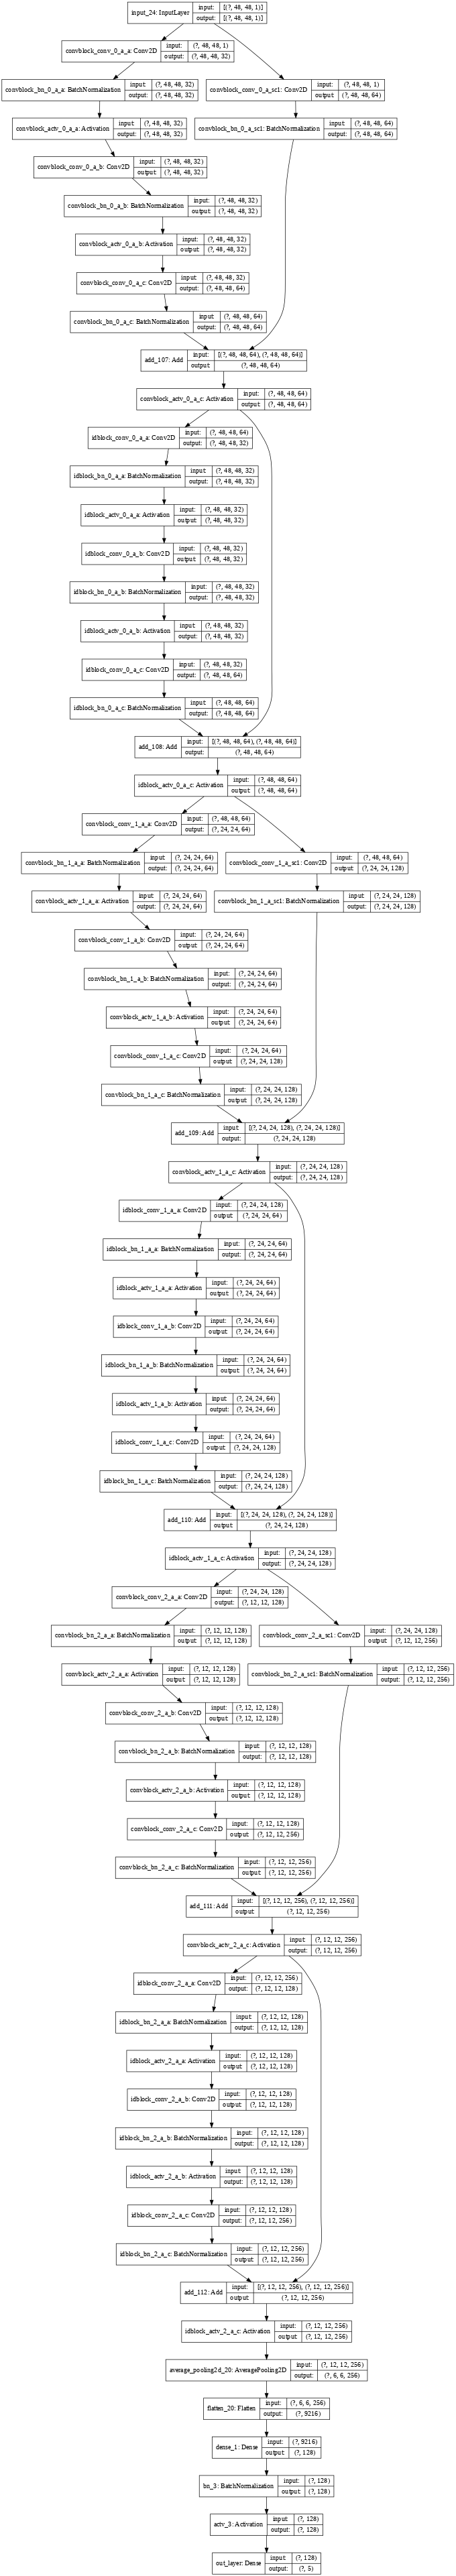

In [0]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50,)# to_file=BASE_PATH+'cnn.png')

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

In [0]:
BEST_CONFIG = {
    "batch_size": 64,
    "epochs": 75,
    "loss": "categorical_crossentropy",
    "optim": optimizers.Adam(0.01),
    "train_datagen": train_datagen,
    "callbacks": [lr_scheduler, early_stopping],
}

In [0]:
model.compile(
        loss=BEST_CONFIG["loss"],
        optimizer=BEST_CONFIG["optim"],
        metrics=['accuracy']
)

BEST_CONFIG["train_datagen"].fit(X_train)
history = model.fit(
    BEST_CONFIG["train_datagen"].flow(X_train, y_train, batch_size=BEST_CONFIG["batch_size"]),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / BEST_CONFIG["batch_size"],
    epochs=BEST_CONFIG["epochs"],
    callbacks=BEST_CONFIG["callbacks"],
)

Epoch 1/75
78/77 [==============================] - 11s 146ms/step - loss: 1.4246 - accuracy: 0.3874 - val_loss: 1.5178 - val_accuracy: 0.2991 - lr: 0.0100
Epoch 2/75
78/77 [==============================] - 10s 130ms/step - loss: 1.1614 - accuracy: 0.5087 - val_loss: 5.0397 - val_accuracy: 0.2460 - lr: 0.0100
Epoch 3/75
78/77 [==============================] - 10s 131ms/step - loss: 1.0057 - accuracy: 0.5723 - val_loss: 7.7939 - val_accuracy: 0.3943 - lr: 0.0100
Epoch 4/75
78/77 [==============================] - 10s 130ms/step - loss: 0.9046 - accuracy: 0.6297 - val_loss: 1.5378 - val_accuracy: 0.3832 - lr: 0.0100
Epoch 5/75
78/77 [==============================] - 10s 131ms/step - loss: 0.8303 - accuracy: 0.6557 - val_loss: 1.0764 - val_accuracy: 0.5698 - lr: 0.0100
Epoch 6/75
78/77 [==============================] - 10s 131ms/step - loss: 0.7936 - accuracy: 0.6690 - val_loss: 0.9923 - val_accuracy: 0.6131 - lr: 0.0100
Epoch 7/75
78/77 [==============================] - 10s 130ms/st

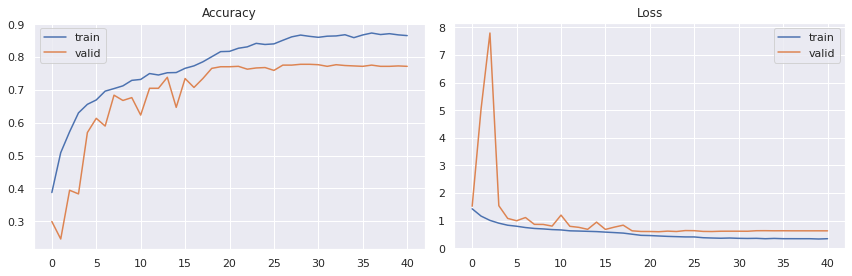

In [0]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

# pyplot.savefig(BASE_PATH+f'epoch_metrics/cnn_{DATA}_{NUM_CLASSES}emo.png')
pyplot.show()

In [0]:
label_to_text

{0: 'Neutral', 1: 'Angry', 2: 'Surprise', 3: 'Sadness', 4: 'Happy'}

test accuracy: 77.7503 %


              precision    recall  f1-score   support

           0       0.67      0.68      0.68       172
           1       0.73      0.82      0.78       131
           2       1.00      1.00      1.00        35
           3       0.66      0.58      0.62       162
           4       0.88      0.89      0.89       309

    accuracy                           0.78       809
   macro avg       0.79      0.79      0.79       809
weighted avg       0.78      0.78      0.78       809



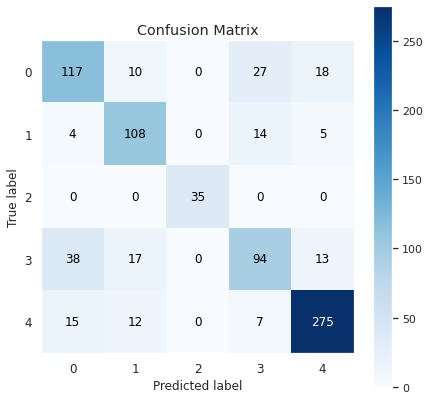

In [0]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
# pyplot.savefig(BASE_PATH+f"confusion_matrix/cnn_{DATA}_{NUM_CLASSES}emo.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [0]:
yhat_train = np.argmax(model.predict(X_train), axis=1)
ytrain_ = np.argmax(y_train, axis=1)

train_accu = np.sum(ytrain_ == yhat_train) / len(ytrain_) * 100
print(f"train accuracy: {round(train_accu, 4)} %")

train accuracy: 88.618 %
